# Onset detector comparison
An evaluation of different onset detectors on a test set of monophonic violin, vocals and whistling recordings where the ground truth is pitch annotations created by human listeners. The onset detectors are part of a great library called [madmom](https://github.com/CPJKU/madmom) by Sebastian Böck et al.

In [1]:
import os
import glob
from collections import defaultdict
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt
import pandas as pd
import librosa as lr
import mir_eval as me
from madmom.features.onsets import (CNNOnsetProcessor, 
                                    RNNOnsetProcessor, 
                                    SpectralOnsetProcessor,
                                    PeakPickingProcessor)
from madmom.processors import SequentialProcessor

%matplotlib inline

In [2]:
DATASET_ROOT = input('Path to dataset:')

Path to dataset:/home/carl/Dropbox/Datasets/monophonic testset 1


In [3]:
def samples_paths(dataset_root=DATASET_ROOT):
    for audio_path in glob.glob(os.path.join(dataset_root, '**/*.wav'), recursive=True):
        directory, file = os.path.dirname(audio_path), os.path.basename(audio_path)
        name, extension = os.path.splitext(file)
        annotation_path = os.path.join(os.path.split(directory)[0], 'ann', name + '.lab')
        instrument = os.path.split(os.path.split(directory)[0])[-1]
        yield name, instrument, audio_path, annotation_path

In [4]:
onset_detectors = [CNNOnsetProcessor(),
                   RNNOnsetProcessor(),
                   SpectralOnsetProcessor(method='superflux')]
# TODO Also test normal spectral flux etc. for reference.
#[SpectralOnsetProcessor(onset_method=m) for m in SpectralOnsetProcessor.METHODS]
onset_detectors = [SequentialProcessor([x, PeakPickingProcessor()]) 
                   for x in onset_detectors]

In [5]:
def evaluate_onset_detector(onset_detector):
    d = defaultdict(list)
    for name, instrument, audio_path, annotation_path in samples_paths():
        d['Song'].append(name)
        d['Instrument'].append(instrument)
        
        # Load human created reference annotation.
        reference_annotation = pd.read_csv(annotation_path, 
                                           delimiter='\t',
                                           names=['Note', 'Onset', 'Offset'])
        reference_annotation = reference_annotation.sort_values(by='Onset')
        
        # Detect onsets.
        estimated_onsets = onset_detector(audio_path)
        
        # Compare estimated onsets with reference.
        scores = me.onset.evaluate(reference_annotation['Onset'], estimated_onsets)
        for k, v in scores.items():
            d[k].append(v)
            
    evaluation_results = pd.DataFrame(dict(zip(d.keys(), map(pd.Series, d.values()))))
    evaluation_results['Method'] = onset_detector.processors[0].__class__.__name__
    return evaluation_results


with Pool(min(len(onset_detectors), cpu_count())) as p:
    dfs = p.map(evaluate_onset_detector, onset_detectors)
    df = pd.concat(dfs)

/home/carl/anaconda3/lib/python3.5/site-packages/mir_eval/util.py:777: RuntimeWarning: invalid value encountered in less
  if (np.diff(events) < 0).any():
/home/carl/anaconda3/lib/python3.5/site-packages/mir_eval/util.py:713: RuntimeWarning: invalid value encountered in less_equal
  hits = np.where(distance(ref, est) <= window)
/home/carl/anaconda3/lib/python3.5/site-packages/mir_eval/util.py:777: RuntimeWarning: invalid value encountered in less
  if (np.diff(events) < 0).any():
/home/carl/anaconda3/lib/python3.5/site-packages/mir_eval/util.py:713: RuntimeWarning: invalid value encountered in less_equal
  hits = np.where(distance(ref, est) <= window)
/home/carl/anaconda3/lib/python3.5/site-packages/mir_eval/util.py:777: RuntimeWarning: invalid value encountered in less
  if (np.diff(events) < 0).any():
/home/carl/anaconda3/lib/python3.5/site-packages/mir_eval/util.py:713: RuntimeWarning: invalid value encountered in less_equal
  hits = np.where(distance(ref, est) <= window)
/home/carl

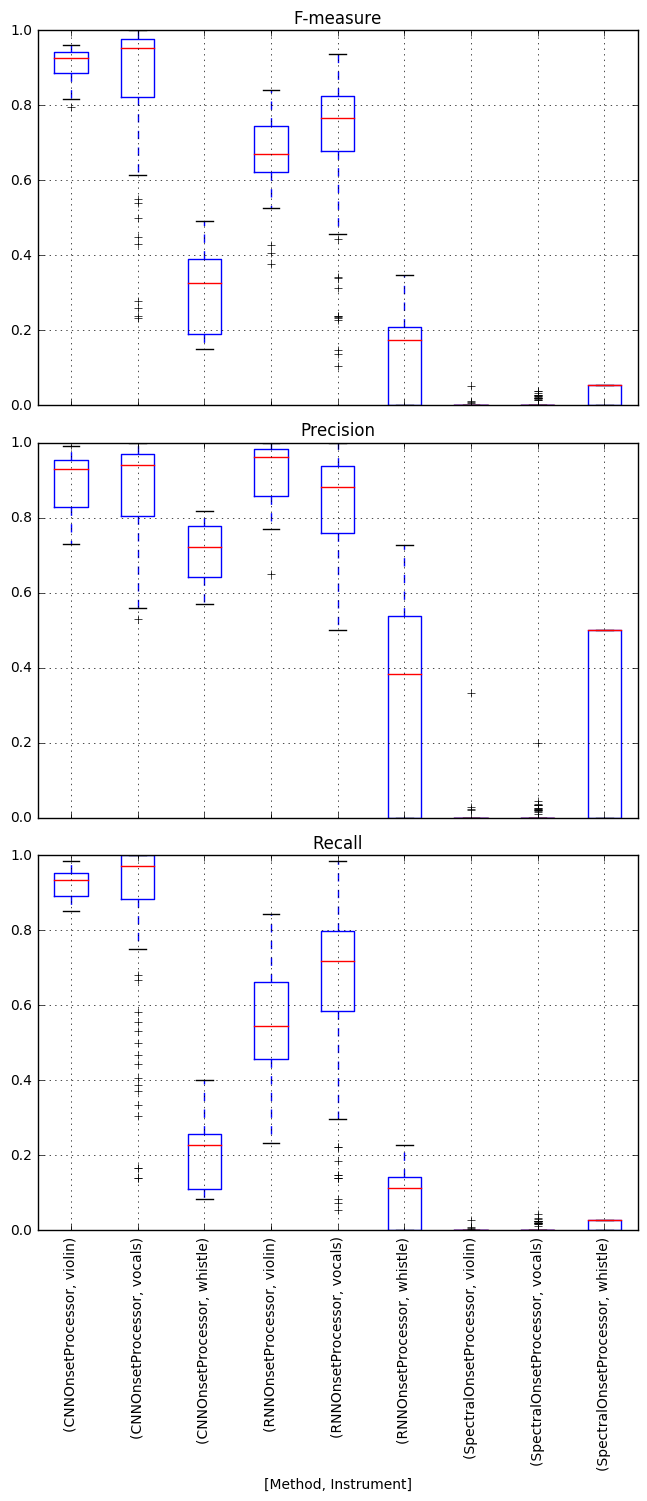

In [6]:
df.boxplot(by=['Method', 'Instrument'], rot=90, layout=(3, 1))
plt.suptitle('')
plt.subplots_adjust(left=0, bottom=0, right=1, top=3, wspace=0, hspace=0.1)